In [ ]:
# Intalacion de librerias necesarias y descarga de archivos necesarios
!pip install pandas numpy matplotlib seaborn sklearn tensorflow gensim

!git init
!git remote add origin https://github.com/dsierra26/proyecto_fundamentos_DL.git
!git config core.sparseCheckout true

!echo "otros/*" > .git/info/sparse-checkout
!echo "!otros/*.h5" >> .git/info/sparse-checkout

!git pull origin main

## 1. Introducción

En esta iteración final, se introduce el uso de capas LSTM bidireccionales, permitiendo que el modelo procese la información en ambas direcciones dentro de la secuencia. Adicionalmente, el entrenamiento se lleva a cabo durante 20 épocas, manteniendo el embedding preentrenado basado en el método *CBOW* (`sg=0`).

El embedding alimenta dos capas bidireccionales LSTM con 128 y 64 unidades respectivamente, intercaladas con capas de Dropout para regularización. La capa de salida sigue siendo una densa con activación sigmoide para producir probabilidades binarias.

La configuración de pérdida y métricas se mantiene igual, utilizando la entropía cruzada binaria como función de pérdida y evaluando el desempeño en términos de precisión (*accuracy*) y sensibilidad (*recall*). Este diseño busca explorar si las capas bidireccionales ofrecen mejoras significativas en el desempeño para esta tarea de clasificación binaria.

## 2. Carga de Datos

In [ ]:
# Importar librerías
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, roc_curve, auc
from sklearn.calibration import calibration_curve
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM, Dropout, Bidirectional
from keras.optimizers import Adam
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from gensim.models import Word2Vec
from IPython.display import Image, display

# Estilo de gráficos
sns.set(style="whitegrid")
plt.rcParams['figure.figsize'] = (10, 6)

# Cargar los datos
df = pd.read_csv('otros/data/clean_subset.csv')
df.info()

2024-11-19 20:38:37.098974: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1732048717.116702  103309 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1732048717.122205  103309 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-11-19 20:38:37.140359: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   hadm_id  1000 non-null   int64 
 1   text     1000 non-null   object
 2   los      1000 non-null   int64 
 3   blos     1000 non-null   int64 
dtypes: int64(3), object(1)
memory usage: 31.4+ KB


In [2]:
# Dividir los datos en Train y Test
X = df['text']
y = df['blos']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"Tamaño de entrenamiento: {X_train.shape}")
print(f"Tamaño de prueba: {X_test.shape}")

Tamaño de entrenamiento: (800,)
Tamaño de prueba: (200,)


## 3. Preprocesamiento de Datos

In [3]:
# Tokenizar el conjunto de entrenamiento
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)

# Convertir `X_train` y `X_test` en secuencias de tokens
X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)

# Obtener el índice de palabras del tokenizer
word_index = tokenizer.word_index
vocab_size = len(word_index) + 1

In [4]:
# Seleccion de la longitud maxima para realizar el padding
sequence_lengths = [len(seq) for seq in X_train_seq]
max_sequence_length = int(np.percentile(sequence_lengths, 95))
# En este caso se define una longitud que abarque al menos el 95% de las historias clinicas para ek cinjunto de datos originales 
# el valor fue de max_secuence_lenhth = 1908
 
# Rellenar o truncar secuencias en ambos conjuntos
X_train_padded = pad_sequences(X_train_seq, maxlen=max_sequence_length, padding='post')
X_test_padded = pad_sequences(X_test_seq, maxlen=max_sequence_length, padding='post')

##  4. Entrenamiento del Modelo Word2Vec

In [5]:
# Crear listas de listas de palabras para entrenar Word2Vec
sentences = [text.split() for text in X_train]

# Entrenar el modelo Word2Vec
embedding_dim = 100
word2vec_model = Word2Vec(sentences=sentences, vector_size=embedding_dim, window=5, min_count=1)

# Generar la matriz para alamcenar los pesos
embedding_matrix = np.zeros((vocab_size, embedding_dim))

for word, i in word_index.items():
    if word in word2vec_model.wv:
        embedding_matrix[i] = word2vec_model.wv[word]

## 5. Construcción y Entrenamiento del Modelo

In [6]:
model = Sequential()
model.add(Embedding(input_dim=vocab_size,
                    output_dim=embedding_dim,
                    weights=[embedding_matrix],
                    input_length=max_sequence_length,
                    trainable=False))
model.add(Bidirectional(LSTM(units=128, return_sequences=True)))
model.add(Dropout(0.3))
model.add(Bidirectional(LSTM(units=64)))
model.add(Dropout(0.3))
model.add(Dense(units=1, activation='sigmoid'))

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy', 'recall'])

/home/dsierra/miniconda3/envs/mimic/lib/python3.9/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(
I0000 00:00:1732048722.925918  103309 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 11549 MB memory:  -> device: 0, name: NVIDIA TITAN X (Pascal), pci bus id: 0000:84:00.0, compute capability: 6.1


In [7]:
model.fit(X_train_padded, y_train, epochs=20, batch_size=32, validation_data=(X_test_padded, y_test))

Epoch 1/20


I0000 00:00:1732048727.453297  104202 cuda_dnn.cc:529] Loaded cuDNN version 90300


25/25 ━━━━━━━━━━━━━━━━━━━━ 12s 268ms/step - accuracy: 0.7408 - loss: 0.5554 - recall: 0.0629 - val_accuracy: 0.8050 - val_loss: 0.4954 - val_recall: 0.1364
Epoch 2/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 6s 248ms/step - accuracy: 0.7933 - loss: 0.5291 - recall: 0.2220 - val_accuracy: 0.8050 - val_loss: 0.4984 - val_recall: 0.1364
Epoch 3/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 6s 248ms/step - accuracy: 0.8091 - loss: 0.5010 - recall: 0.1894 - val_accuracy: 0.8050 - val_loss: 0.4994 - val_recall: 0.1364
Epoch 4/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 6s 249ms/step - accuracy: 0.8068 - loss: 0.4943 - recall: 0.1548 - val_accuracy: 0.8050 - val_loss: 0.5011 - val_recall: 0.1364
Epoch 5/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 6s 247ms/step - accuracy: 0.8175 - loss: 0.4716 - recall: 0.1832 - val_accuracy: 0.8000 - val_loss: 0.5064 - val_recall: 0.1136
Epoch 6/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 6s 250ms/step - accuracy: 0.7916 - loss: 0.5106 - recall: 0.1308 - val_accuracy: 0.8050 - val_loss: 0.5020 - val_recall: 0.1364
Epoch 7/20
25/

## 6. Evaluación del Modelo

In [8]:
# Predicción sobre el conjunto de prueba
y_pred = model.predict(X_test_padded)

y_pred_class = (y_pred > 0.4).astype('int32')

7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 144ms/step


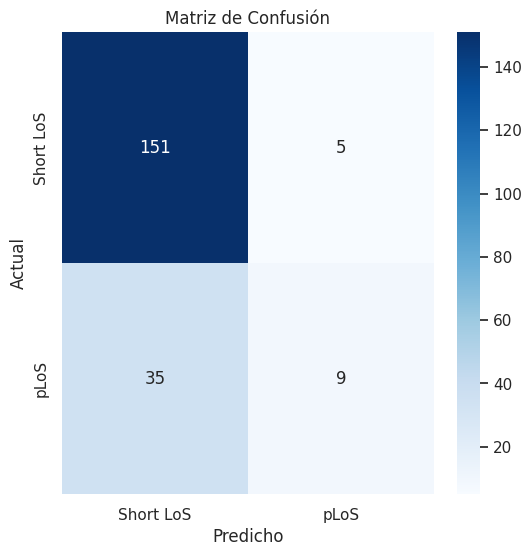

In [9]:
# Matriz de confusión
cm = confusion_matrix(y_test, y_pred_class)

plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=["Short LoS", "pLoS"], yticklabels=["Short LoS", "pLoS"])
plt.ylabel('Actual')
plt.xlabel('Predicho')
plt.title('Matriz de Confusión')
plt.show()

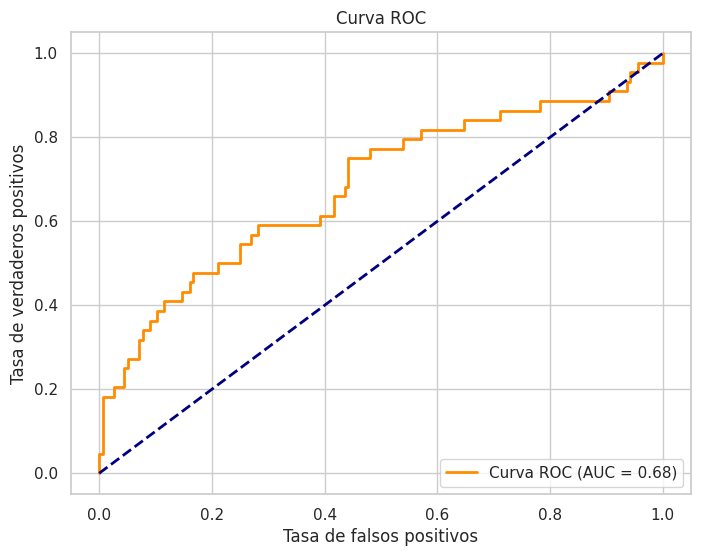

In [10]:
# Curva ROC
fpr, tpr, thresholds = roc_curve(y_test, y_pred)

# Calcular el AUC
roc_auc = auc(fpr, tpr)

# Graficar la curva ROC
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='Curva ROC (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('Tasa de falsos positivos')
plt.ylabel('Tasa de verdaderos positivos')
plt.title('Curva ROC')
plt.legend(loc='lower right')
plt.show()

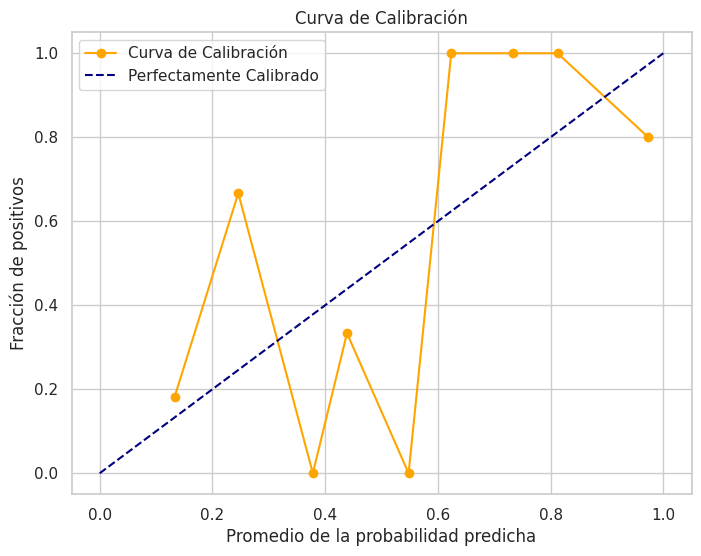

In [11]:
# Curva de calibración
fraction_of_positives, mean_predicted_value = calibration_curve(y_test, y_pred, n_bins=10)

plt.figure(figsize=(8, 6))
plt.plot(mean_predicted_value, fraction_of_positives, color="orange", marker="o", label="Curva de Calibración")
plt.plot([0, 1], [0, 1], color="navy", linestyle="--", label="Perfectamente Calibrado")
plt.xlabel('Promedio de la probabilidad predicha')
plt.ylabel('Fracción de positivos')
plt.title('Curva de Calibración')
plt.legend()
plt.show()

## 7. Resultados sobre el Conjunto de Datos original

En esta sección se presentan los resultados obtenidos al evaluar el modelo base de clasificacion entrenado sobre los datos originales, utilizando los embeddings con **sg=0** y **10 epochs**, sobre el conjunto de datos de testeo original.


### Matriz de confusión

![Matriz de confusión](otros/confusion_matrix_clas_03.png)


### Curva ROC

![Curva ROC](otros/roc_curve_clas_03.png)

### Curva de calibración

![Curva de calibración](otros/calibration_curve_clas_03.png)

In [ ]:
display(Image(filename="otros/confusion_matrix_clas_03.png"))
display(Image(filename="otros/roc_curve_clas_03.png"))
display(Image(filename="otros/calibration_curve_clas_03.png"))

In [ ]:
# Cargar el modelo entrenado sobre los datos originales las lineas estan comentadas porque los modelos son muy pesados para
# cargarlos en el colab, pero el archivo con el modelo se encuentra en el repositorio

#model = load_model('otros/modelo_clasification_03.h5')
#model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy', 'recall'])
#model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_2 (Embedding)         │ (None, 1908, 100)      │    80,658,900 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (None, 1908, 256)      │       234,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 1908, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ (None, 128)            │       164,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 81,057,877 (309.21 MB)

 Trainable params: 398,977 (1.52 MB)

 Non-trainable params: 80,658,900 (307.69 MB)